In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchtext.data import Field, BucketIterator
from sklearn.model_selection import train_test_split, KFold
from torchtext.vocab import build_vocab_from_iterator
import re
from transformers import BertTokenizer
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import F1Score
import optuna
import warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
from utils import *

# Import data

In [3]:
FOLDS = 5 # number of folds for CV (== number of fusions tried)
SEED = 2022

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# import data
data = import_data()

In [6]:
%%time
# preprocessing (tokenization, discard long sentence, lowercase etc.)
data = preproc(data)

Tokenizing the data...
Length of the data :  29544
CPU times: total: 4min 5s
Wall time: 4min 18s


In [41]:
%%time
# data split (CV)
datasets = []
cv = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for i, (train_indices, test_indices) in enumerate(cv.split(data)):
    train_set, test_set = data.loc[train_indices, :], data.loc[test_indices, :]

    datasets.append((train_set, test_set))

CPU times: total: 31.2 ms
Wall time: 26 ms


# CV

### Definition

In [42]:
LEARNING_RATE = 2e-4 # starting learning rate for scheduler
EPOCHS = 'unrestricted' # use 'unrestricted' for full convergence

In [43]:
# template for training parent models (as we train them the same way)
def train_early_stopping(model_name: str, train_iter, valid_iter, embedding, pad_idx, voc_size, device, epochs='unrestricted', lr=2e-4, save=True):
    # init
    model = new_model(embedding, pad_idx, voc_size, device) # init model

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # train with early stopping
    history = train(model=model,
                    iterator=train_iter,
                    valid_iter=valid_iter,
                    optimizer=opt,
                    criterion=loss_fn,
                    epoch=epochs,
                    clip=1,
                    device=device)

    if save:
        # save model
        name = f'parallel_training/model{model_name}_IMDB_256'
        save_model(model, name=name)

        # save history
        name = f'parallel_training/history_model{model_name}_IMDB_256'
        save_history(history, name=name)

    return model

In [44]:
probability_mass_distribution_names = ['uniform', 'random', 'gaussian', 'geometric']

### Evaluation

In [45]:
model_names = ['A', 'B',
               'vanilla_pre', 'vanilla_post',
               'OT_pre_uniform', 'OT_post_uniform',
               'OT_pre_random', 'OT_post_random',
               'OT_pre_gaussian', 'OT_post_gaussian',
               'OT_pre_geometric', 'OT_post_geometric',
               'random']
scores = {'loss': {model_name: [] for model_name in model_names},
          'accuracy': {model_name: [] for model_name in model_names},
          'f1': {model_name: [] for model_name in model_names},}

Fold 1/5
Vocabulary Size :  23044


100%|██████████| 5908/5908 [00:00<00:00, 20061.92it/s]


Positive labels ratio (train set): 0.5019461837874429
Positive labels ratio (test set): 0.506093432633717
Dataset initializing done
Starting training for model A


Epoch: 89 - Train Loss: 0.1957 / Validation Loss: 0.5110 / Train acc: 0.9273 / Val acc: 0.8000 / Learning Rate : 0.0000:   0%|          | 89/1000000 [03:15<605:32:15,  2.18s/it]

Training has converged after 89 epochs (lr < 1e-06)


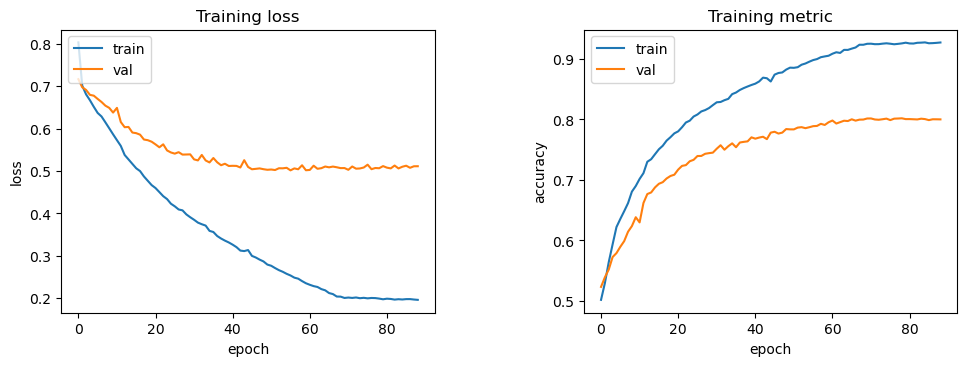

Epoch: 89 - Train Loss: 0.1957 / Validation Loss: 0.5110 / Train acc: 0.9273 / Val acc: 0.8000 / Learning Rate : 0.0000:   0%|          | 89/1000000 [03:15<611:21:58,  2.20s/it]


Starting training for model B


Epoch: 43 - Train Loss: 0.1871 / Validation Loss: 0.4147 / Train acc: 0.9305 / Val acc: 0.8310 / Learning Rate : 0.0000:   0%|          | 43/1000000 [01:33<608:19:21,  2.19s/it]

Training has converged after 43 epochs (lr < 1e-06)


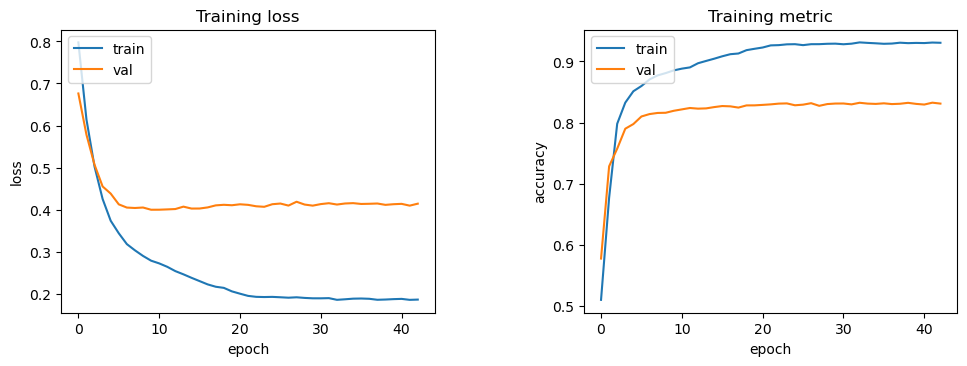

Epoch: 43 - Train Loss: 0.1871 / Validation Loss: 0.4147 / Train acc: 0.9305 / Val acc: 0.8310 / Learning Rate : 0.0000:   0%|          | 43/1000000 [01:33<606:02:51,  2.18s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion suc

Epoch: 143 - Train Loss: 0.1959 / Validation Loss: 0.4407 / Train acc: 0.9366 / Val acc: 0.8054 / Learning Rate : 0.0000:   0%|          | 143/1000000 [04:56<575:52:15,  2.07s/it]

Training has converged after 143 epochs (lr < 1e-06)


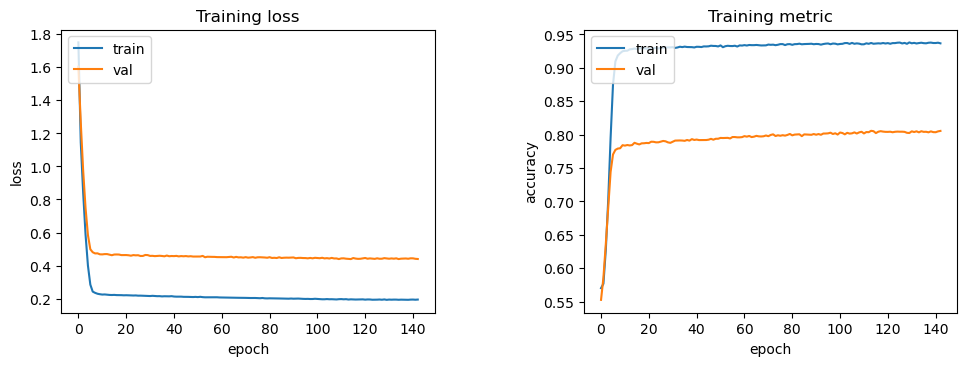

Epoch: 143 - Train Loss: 0.1959 / Validation Loss: 0.4407 / Train acc: 0.9366 / Val acc: 0.8054 / Learning Rate : 0.0000:   0%|          | 143/1000000 [04:57<576:56:07,  2.08s/it]


Starting retraining for model OT fusion - uniform


Epoch: 192 - Train Loss: 0.1969 / Validation Loss: 0.4815 / Train acc: 0.9279 / Val acc: 0.7984 / Learning Rate : 0.0000:   0%|          | 192/1000000 [06:37<576:21:18,  2.08s/it]

Training has converged after 192 epochs (lr < 1e-06)


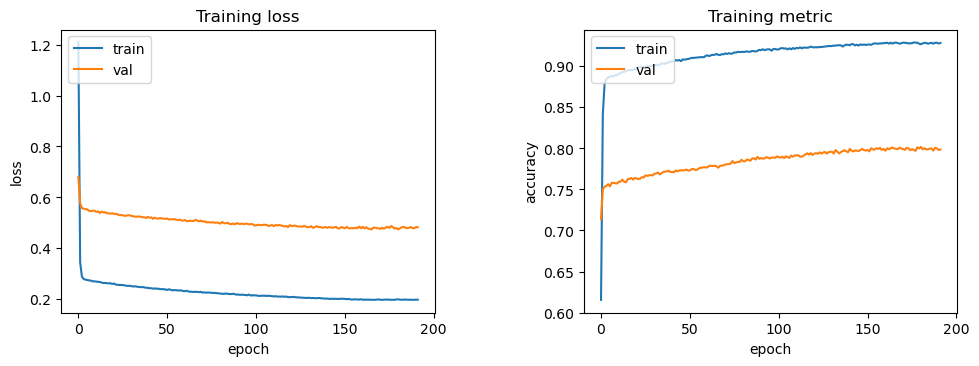

Epoch: 192 - Train Loss: 0.1969 / Validation Loss: 0.4815 / Train acc: 0.9279 / Val acc: 0.7984 / Learning Rate : 0.0000:   0%|          | 192/1000000 [06:37<575:28:04,  2.07s/it]


Starting retraining for model OT fusion - random


Epoch: 189 - Train Loss: 0.1966 / Validation Loss: 0.4827 / Train acc: 0.9282 / Val acc: 0.7988 / Learning Rate : 0.0000:   0%|          | 189/1000000 [06:31<571:28:23,  2.06s/it]

Training has converged after 189 epochs (lr < 1e-06)


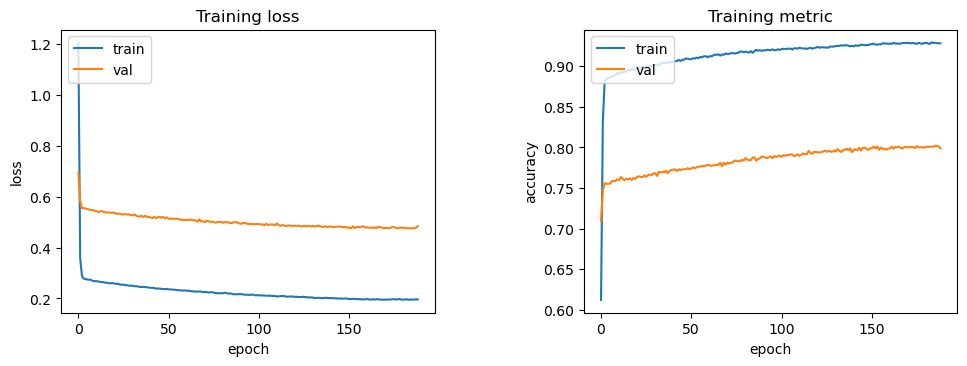

Epoch: 189 - Train Loss: 0.1966 / Validation Loss: 0.4827 / Train acc: 0.9282 / Val acc: 0.7988 / Learning Rate : 0.0000:   0%|          | 189/1000000 [06:32<576:02:33,  2.07s/it]


Starting retraining for model OT fusion - gaussian


Epoch: 207 - Train Loss: 0.1936 / Validation Loss: 0.4755 / Train acc: 0.9293 / Val acc: 0.8005 / Learning Rate : 0.0000:   0%|          | 207/1000000 [07:08<579:37:02,  2.09s/it]

Training has converged after 207 epochs (lr < 1e-06)


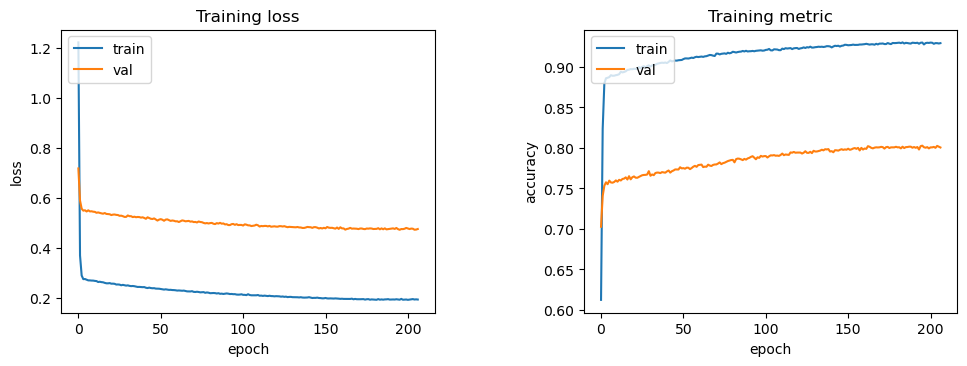

Epoch: 207 - Train Loss: 0.1936 / Validation Loss: 0.4755 / Train acc: 0.9293 / Val acc: 0.8005 / Learning Rate : 0.0000:   0%|          | 207/1000000 [07:08<575:26:17,  2.07s/it]


Starting retraining for model OT fusion - geometric


Epoch: 149 - Train Loss: 0.2073 / Validation Loss: 0.4871 / Train acc: 0.9225 / Val acc: 0.7937 / Learning Rate : 0.0000:   0%|          | 149/1000000 [05:08<579:14:40,  2.09s/it]

Training has converged after 149 epochs (lr < 1e-06)


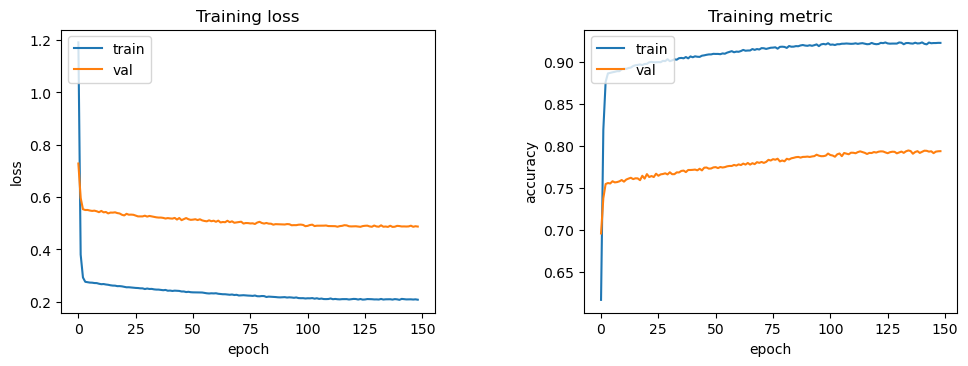

Epoch: 149 - Train Loss: 0.2073 / Validation Loss: 0.4871 / Train acc: 0.9225 / Val acc: 0.7937 / Learning Rate : 0.0000:   0%|          | 149/1000000 [05:09<576:06:47,  2.07s/it]


OT_post_uniform loss: 0.4940035218993823 - accuracy: 0.7928248603562802 - f1: 0.7926540374755859
OT_post_random loss: 0.4860522747039795 - accuracy: 0.7954549743357489 - f1: 0.7965470552444458
OT_post_gaussian loss: 0.47809310505787533 - accuracy: 0.7990805215881642 - f1: 0.7995937466621399
OT_post_geometric loss: 0.4866243799527486 - accuracy: 0.7929876207729469 - f1: 0.792823314666748
vanilla_post loss: 0.4779366801182429 - accuracy: 0.7893809442934782 - f1: 0.7879146933555603
Fold 2/5
Vocabulary Size :  23054


100%|██████████| 5909/5909 [00:00<00:00, 21371.54it/s]


Positive labels ratio (train set): 0.5059022635921303
Positive labels ratio (test set): 0.4902690810627856
Dataset initializing done
Starting training for model A


Epoch: 95 - Train Loss: 0.1886 / Validation Loss: 0.5256 / Train acc: 0.9311 / Val acc: 0.7977 / Learning Rate : 0.0000:   0%|          | 95/1000000 [03:26<601:33:52,  2.17s/it]

Training has converged after 95 epochs (lr < 1e-06)


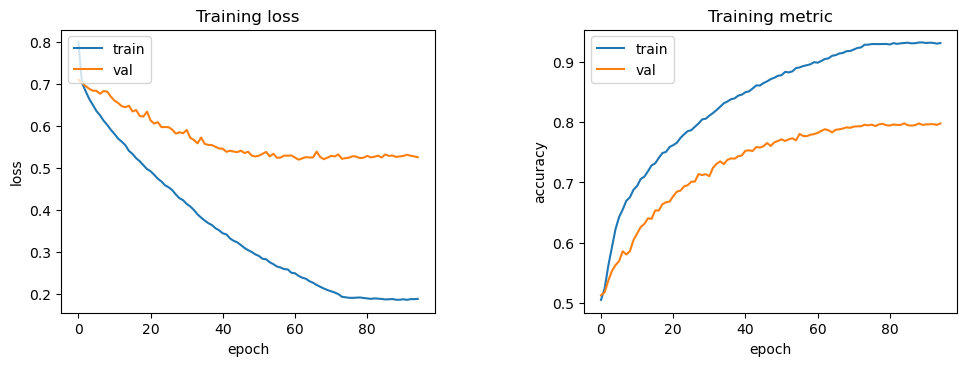

Epoch: 95 - Train Loss: 0.1886 / Validation Loss: 0.5256 / Train acc: 0.9311 / Val acc: 0.7977 / Learning Rate : 0.0000:   0%|          | 95/1000000 [03:26<603:31:24,  2.17s/it]


Starting training for model B


Epoch: 48 - Train Loss: 0.1665 / Validation Loss: 0.4185 / Train acc: 0.9408 / Val acc: 0.8336 / Learning Rate : 0.0000:   0%|          | 48/1000000 [01:44<611:19:30,  2.20s/it]

Training has converged after 48 epochs (lr < 1e-06)


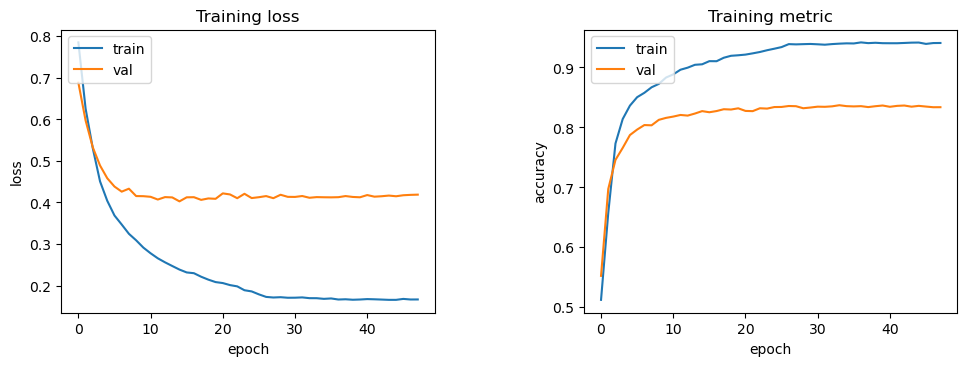

Epoch: 48 - Train Loss: 0.1665 / Validation Loss: 0.4185 / Train acc: 0.9408 / Val acc: 0.8336 / Learning Rate : 0.0000:   0%|          | 48/1000000 [01:44<604:11:02,  2.18s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion suc

Epoch: 69 - Train Loss: 0.1875 / Validation Loss: 0.4629 / Train acc: 0.9391 / Val acc: 0.8032 / Learning Rate : 0.0000:   0%|          | 69/1000000 [02:23<576:53:28,  2.08s/it]

Training has converged after 69 epochs (lr < 1e-06)


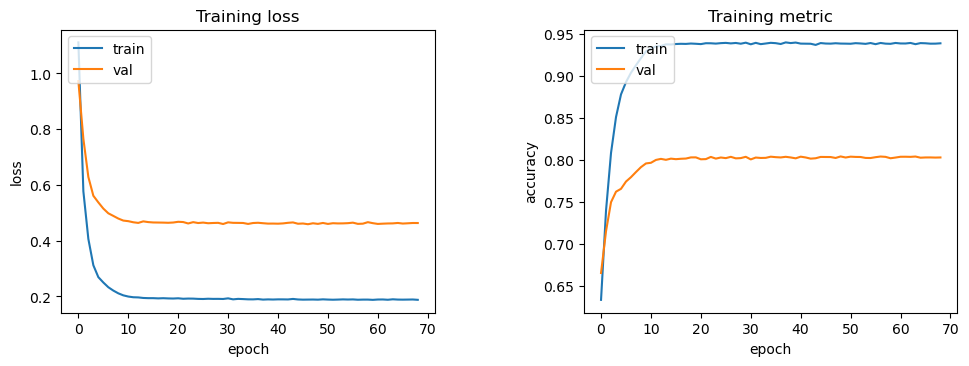

Epoch: 69 - Train Loss: 0.1875 / Validation Loss: 0.4629 / Train acc: 0.9391 / Val acc: 0.8032 / Learning Rate : 0.0000:   0%|          | 69/1000000 [02:23<577:17:17,  2.08s/it]


Starting retraining for model OT fusion - uniform


Epoch: 83 - Train Loss: 0.1883 / Validation Loss: 0.4292 / Train acc: 0.9372 / Val acc: 0.8173 / Learning Rate : 0.0000:   0%|          | 83/1000000 [02:51<570:38:44,  2.05s/it]

Training has converged after 83 epochs (lr < 1e-06)


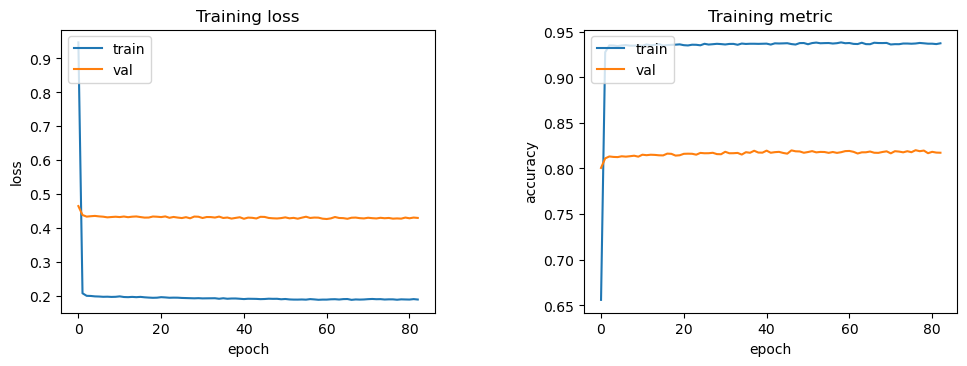

Epoch: 83 - Train Loss: 0.1883 / Validation Loss: 0.4292 / Train acc: 0.9372 / Val acc: 0.8173 / Learning Rate : 0.0000:   0%|          | 83/1000000 [02:51<575:32:19,  2.07s/it]


Starting retraining for model OT fusion - random


Epoch: 93 - Train Loss: 0.1872 / Validation Loss: 0.4272 / Train acc: 0.9377 / Val acc: 0.8185 / Learning Rate : 0.0000:   0%|          | 93/1000000 [03:12<572:09:15,  2.06s/it]

Training has converged after 93 epochs (lr < 1e-06)


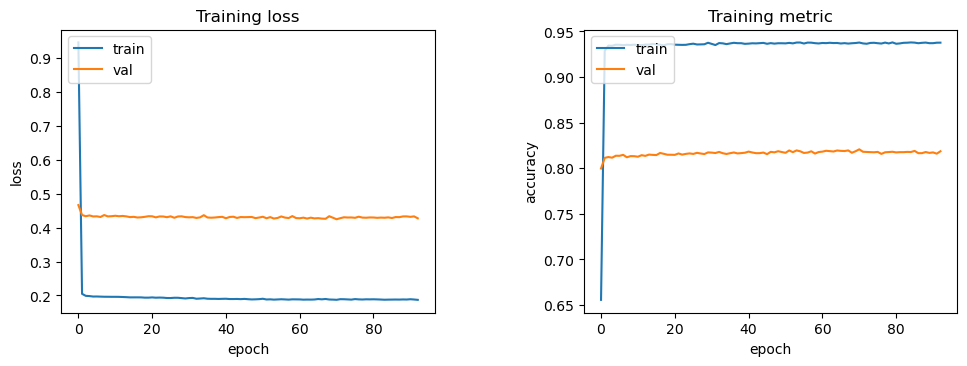

Epoch: 93 - Train Loss: 0.1872 / Validation Loss: 0.4272 / Train acc: 0.9377 / Val acc: 0.8185 / Learning Rate : 0.0000:   0%|          | 93/1000000 [03:12<576:14:32,  2.07s/it]


Starting retraining for model OT fusion - gaussian


Epoch: 40 - Train Loss: 0.1943 / Validation Loss: 0.4314 / Train acc: 0.9358 / Val acc: 0.8166 / Learning Rate : 0.0000:   0%|          | 40/1000000 [01:22<575:10:38,  2.07s/it]

Training has converged after 40 epochs (lr < 1e-06)


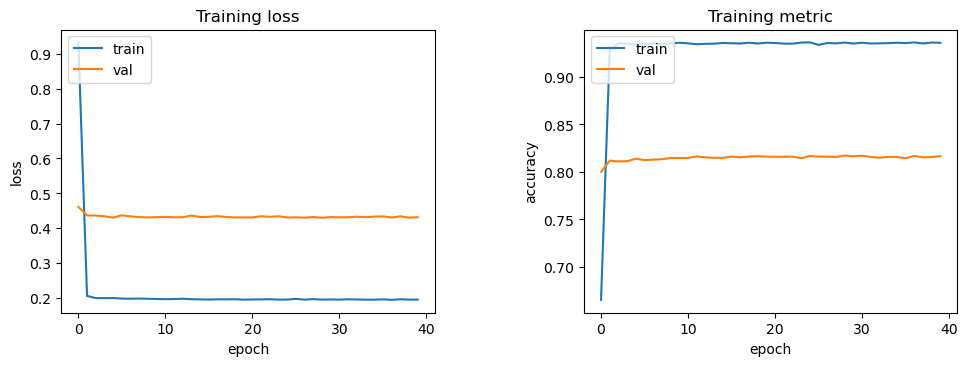

Epoch: 40 - Train Loss: 0.1943 / Validation Loss: 0.4314 / Train acc: 0.9358 / Val acc: 0.8166 / Learning Rate : 0.0000:   0%|          | 40/1000000 [01:23<577:29:50,  2.08s/it]


Starting retraining for model OT fusion - geometric


Epoch: 95 - Train Loss: 0.1883 / Validation Loss: 0.4272 / Train acc: 0.9372 / Val acc: 0.8177 / Learning Rate : 0.0000:   0%|          | 95/1000000 [03:16<577:11:59,  2.08s/it]

Training has converged after 95 epochs (lr < 1e-06)


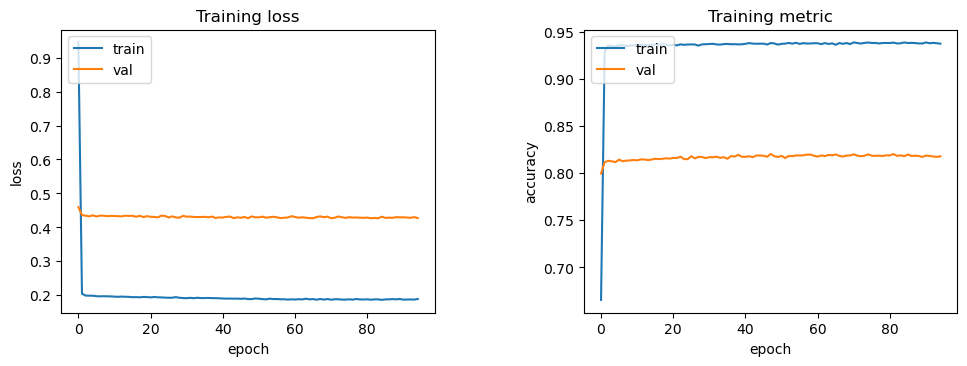

Epoch: 95 - Train Loss: 0.1883 / Validation Loss: 0.4272 / Train acc: 0.9372 / Val acc: 0.8177 / Learning Rate : 0.0000:   0%|          | 95/1000000 [03:16<575:56:04,  2.07s/it]


OT_post_uniform loss: 0.4281337186694145 - accuracy: 0.8179016480520458 - f1: 0.8184126019477844
OT_post_random loss: 0.42735333492358524 - accuracy: 0.8192577889966907 - f1: 0.8182433843612671
OT_post_gaussian loss: 0.43416646122932434 - accuracy: 0.8160619265192539 - f1: 0.81621253490448
OT_post_geometric loss: 0.4283642421166102 - accuracy: 0.8182418584536701 - f1: 0.8179048299789429
vanilla_post loss: 0.45834388335545856 - accuracy: 0.8042050945773165 - f1: 0.8040277361869812
Fold 3/5
Vocabulary Size :  23043


100%|██████████| 5909/5909 [00:00<00:00, 21371.50it/s]


Positive labels ratio (train set): 0.5016289401311614
Positive labels ratio (test set): 0.5073616517177187
Dataset initializing done
Starting training for model A


Epoch: 89 - Train Loss: 0.1875 / Validation Loss: 0.5071 / Train acc: 0.9301 / Val acc: 0.8025 / Learning Rate : 0.0000:   0%|          | 89/1000000 [03:13<604:56:18,  2.18s/it]

Training has converged after 89 epochs (lr < 1e-06)


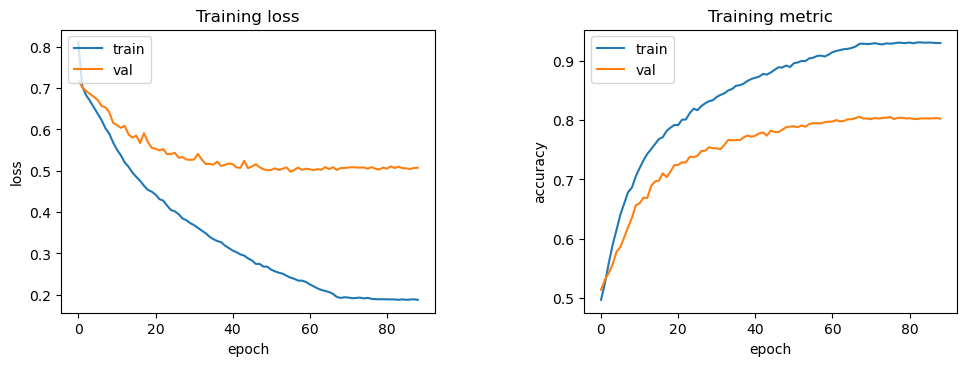

Epoch: 89 - Train Loss: 0.1875 / Validation Loss: 0.5071 / Train acc: 0.9301 / Val acc: 0.8025 / Learning Rate : 0.0000:   0%|          | 89/1000000 [03:13<604:13:24,  2.18s/it]


Starting training for model B


Epoch: 48 - Train Loss: 0.1624 / Validation Loss: 0.4229 / Train acc: 0.9427 / Val acc: 0.8314 / Learning Rate : 0.0000:   0%|          | 48/1000000 [01:44<604:25:45,  2.18s/it]

Training has converged after 48 epochs (lr < 1e-06)


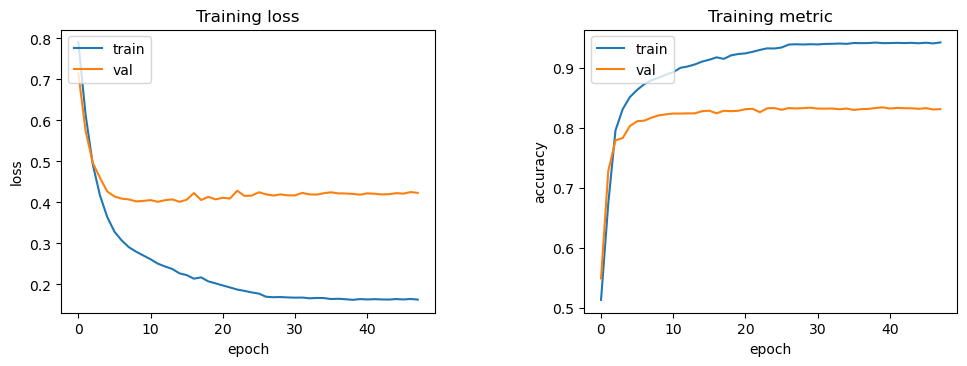

Epoch: 48 - Train Loss: 0.1624 / Validation Loss: 0.4229 / Train acc: 0.9427 / Val acc: 0.8314 / Learning Rate : 0.0000:   0%|          | 48/1000000 [01:44<604:21:59,  2.18s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion suc

Epoch: 186 - Train Loss: 0.1859 / Validation Loss: 0.4568 / Train acc: 0.9384 / Val acc: 0.8083 / Learning Rate : 0.0000:   0%|          | 186/1000000 [06:26<577:47:18,  2.08s/it]

Training has converged after 186 epochs (lr < 1e-06)


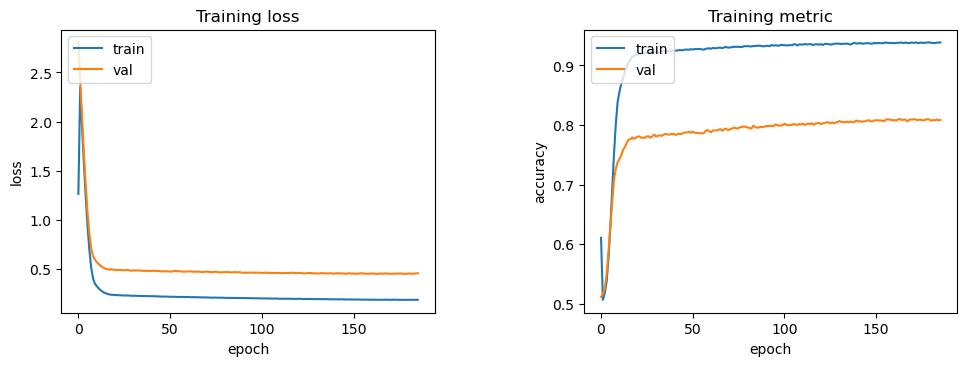

Epoch: 186 - Train Loss: 0.1859 / Validation Loss: 0.4568 / Train acc: 0.9384 / Val acc: 0.8083 / Learning Rate : 0.0000:   0%|          | 186/1000000 [06:26<576:41:07,  2.08s/it]


Starting retraining for model OT fusion - uniform


Epoch: 208 - Train Loss: 0.1793 / Validation Loss: 0.4725 / Train acc: 0.9369 / Val acc: 0.8093 / Learning Rate : 0.0000:   0%|          | 208/1000000 [07:11<575:03:48,  2.07s/it]

Training has converged after 208 epochs (lr < 1e-06)


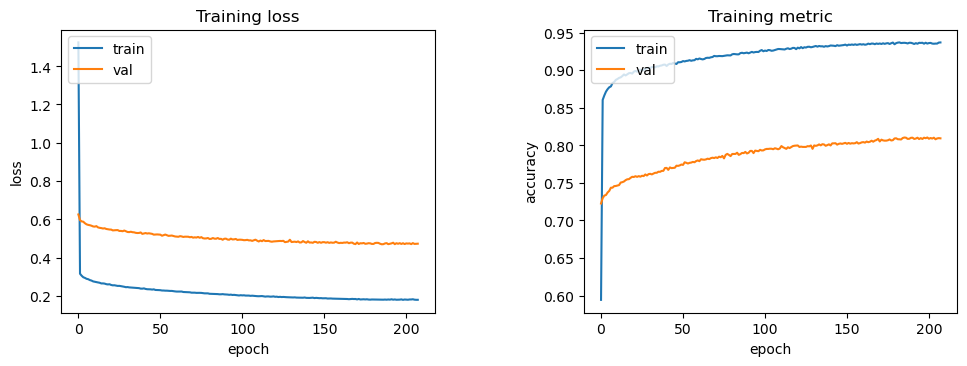

Epoch: 208 - Train Loss: 0.1793 / Validation Loss: 0.4725 / Train acc: 0.9369 / Val acc: 0.8093 / Learning Rate : 0.0000:   0%|          | 208/1000000 [07:11<576:23:37,  2.08s/it]


Starting retraining for model OT fusion - random


Epoch: 223 - Train Loss: 0.1806 / Validation Loss: 0.4721 / Train acc: 0.9360 / Val acc: 0.8103 / Learning Rate : 0.0000:   0%|          | 223/1000000 [07:41<570:39:32,  2.05s/it]

Training has converged after 223 epochs (lr < 1e-06)


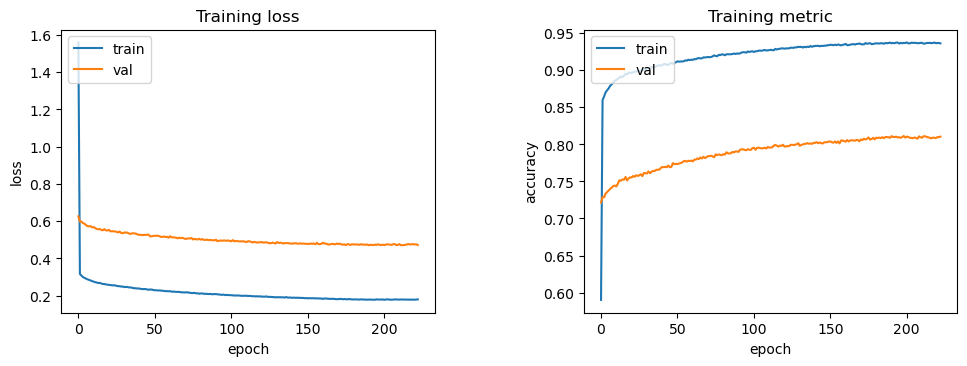

Epoch: 223 - Train Loss: 0.1806 / Validation Loss: 0.4721 / Train acc: 0.9360 / Val acc: 0.8103 / Learning Rate : 0.0000:   0%|          | 223/1000000 [07:42<575:27:16,  2.07s/it]


Starting retraining for model OT fusion - gaussian


Epoch: 190 - Train Loss: 0.1828 / Validation Loss: 0.4736 / Train acc: 0.9348 / Val acc: 0.8058 / Learning Rate : 0.0000:   0%|          | 190/1000000 [06:31<573:53:16,  2.07s/it]

Training has converged after 190 epochs (lr < 1e-06)


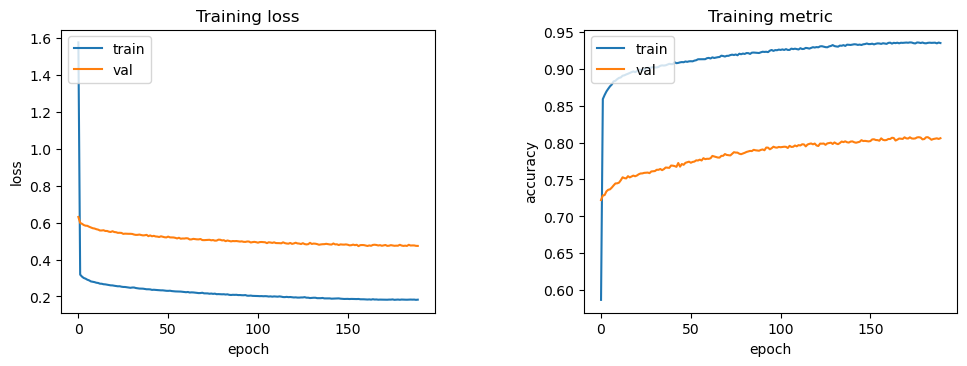

Epoch: 190 - Train Loss: 0.1828 / Validation Loss: 0.4736 / Train acc: 0.9348 / Val acc: 0.8058 / Learning Rate : 0.0000:   0%|          | 190/1000000 [06:31<572:43:08,  2.06s/it]


Starting retraining for model OT fusion - geometric


Epoch: 210 - Train Loss: 0.1792 / Validation Loss: 0.4726 / Train acc: 0.9359 / Val acc: 0.8105 / Learning Rate : 0.0000:   0%|          | 210/1000000 [07:12<570:09:05,  2.05s/it]

Training has converged after 210 epochs (lr < 1e-06)


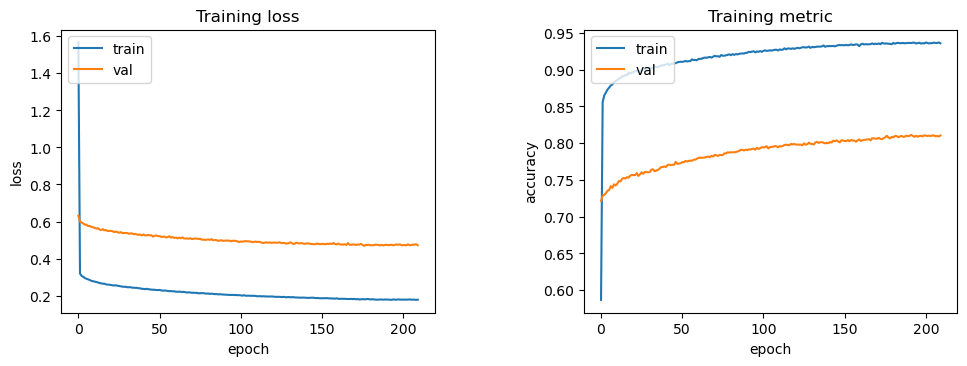

Epoch: 210 - Train Loss: 0.1792 / Validation Loss: 0.4726 / Train acc: 0.9359 / Val acc: 0.8105 / Learning Rate : 0.0000:   0%|          | 210/1000000 [07:12<572:14:20,  2.06s/it]


OT_post_uniform loss: 0.47951631993055344 - accuracy: 0.8064149932310469 - f1: 0.8087663054466248
OT_post_random loss: 0.47565040985743207 - accuracy: 0.8093493813929001 - f1: 0.8099509477615356
OT_post_gaussian loss: 0.4726472422480583 - accuracy: 0.8068486292870035 - f1: 0.8060585260391235
OT_post_geometric loss: 0.4732641503214836 - accuracy: 0.8103406334611913 - f1: 0.810120165348053
vanilla_post loss: 0.4522270659605662 - accuracy: 0.8076230633273165 - f1: 0.8075816631317139
Fold 4/5
Vocabulary Size :  23075


100%|██████████| 5909/5909 [00:00<00:00, 21684.97it/s]


Positive labels ratio (train set): 0.5009519779987307
Positive labels ratio (test set): 0.5100693856828566
Dataset initializing done
Starting training for model A


Epoch: 82 - Train Loss: 0.2160 / Validation Loss: 0.5112 / Train acc: 0.9169 / Val acc: 0.7969 / Learning Rate : 0.0000:   0%|          | 82/1000000 [02:56<602:47:19,  2.17s/it]

Training has converged after 82 epochs (lr < 1e-06)


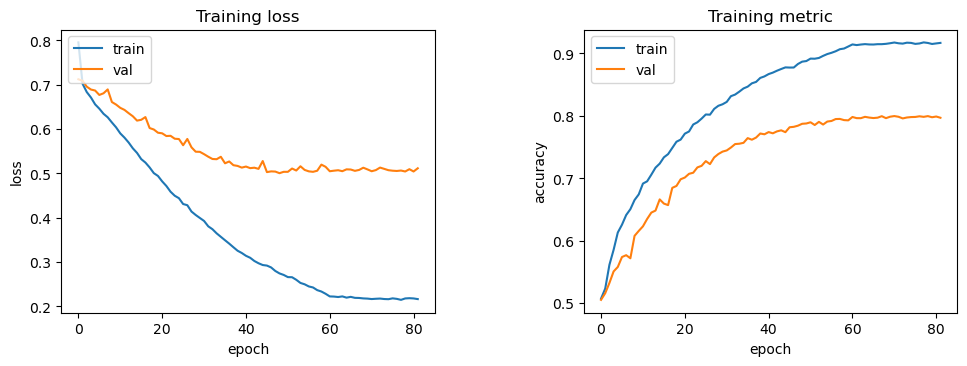

Epoch: 82 - Train Loss: 0.2160 / Validation Loss: 0.5112 / Train acc: 0.9169 / Val acc: 0.7969 / Learning Rate : 0.0000:   0%|          | 82/1000000 [02:57<600:12:07,  2.16s/it]


Starting training for model B


Epoch: 48 - Train Loss: 0.1784 / Validation Loss: 0.4390 / Train acc: 0.9342 / Val acc: 0.8295 / Learning Rate : 0.0000:   0%|          | 48/1000000 [01:43<597:50:40,  2.15s/it]

Training has converged after 48 epochs (lr < 1e-06)


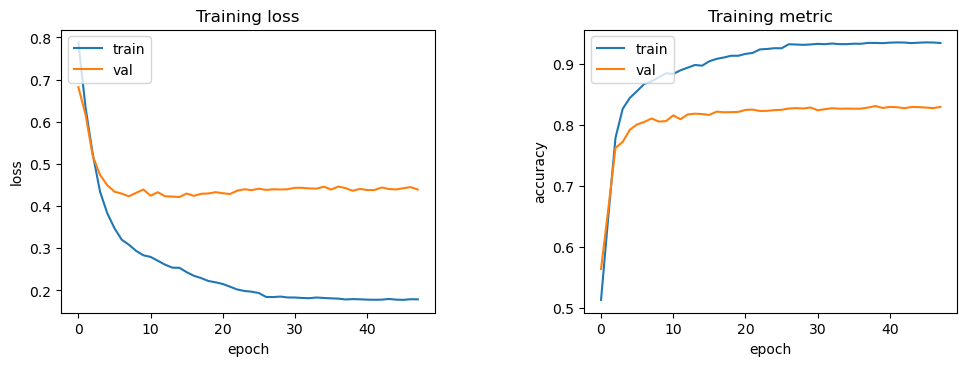

Epoch: 48 - Train Loss: 0.1784 / Validation Loss: 0.4390 / Train acc: 0.9342 / Val acc: 0.8295 / Learning Rate : 0.0000:   0%|          | 48/1000000 [01:43<600:42:54,  2.16s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion suc

Epoch: 93 - Train Loss: 0.2137 / Validation Loss: 0.4709 / Train acc: 0.9264 / Val acc: 0.7936 / Learning Rate : 0.0000:   0%|          | 93/1000000 [03:11<573:14:38,  2.06s/it]

Training has converged after 93 epochs (lr < 1e-06)


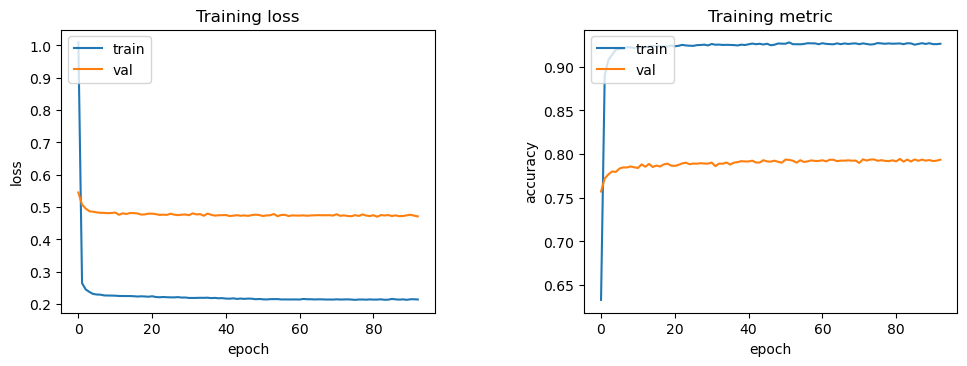

Epoch: 93 - Train Loss: 0.2137 / Validation Loss: 0.4709 / Train acc: 0.9264 / Val acc: 0.7936 / Learning Rate : 0.0000:   0%|          | 93/1000000 [03:12<573:36:46,  2.07s/it]


Starting retraining for model OT fusion - uniform


Epoch: 211 - Train Loss: 0.2011 / Validation Loss: 0.4915 / Train acc: 0.9253 / Val acc: 0.7944 / Learning Rate : 0.0000:   0%|          | 211/1000000 [07:15<576:22:09,  2.08s/it]

Training has converged after 211 epochs (lr < 1e-06)


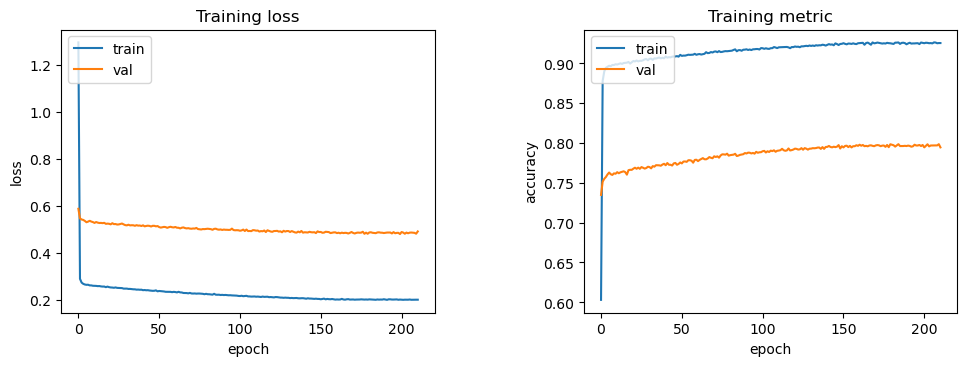

Epoch: 211 - Train Loss: 0.2011 / Validation Loss: 0.4915 / Train acc: 0.9253 / Val acc: 0.7944 / Learning Rate : 0.0000:   0%|          | 211/1000000 [07:15<573:05:23,  2.06s/it]


Starting retraining for model OT fusion - random


Epoch: 171 - Train Loss: 0.2066 / Validation Loss: 0.4894 / Train acc: 0.9233 / Val acc: 0.7933 / Learning Rate : 0.0000:   0%|          | 171/1000000 [05:52<576:35:59,  2.08s/it]

Training has converged after 171 epochs (lr < 1e-06)


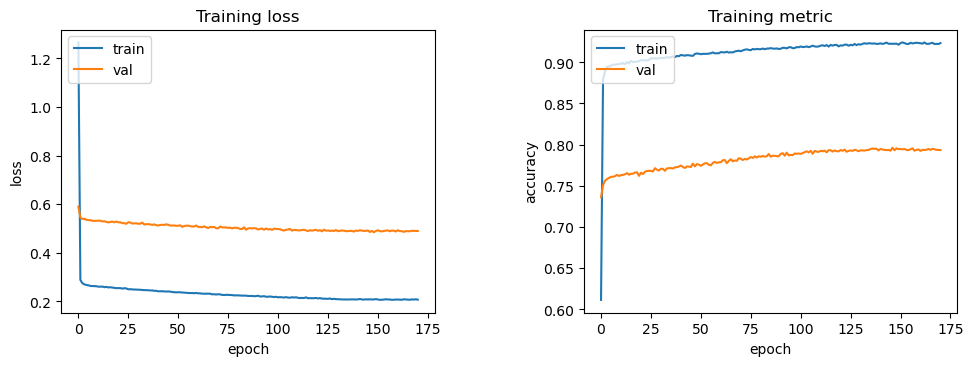

Epoch: 171 - Train Loss: 0.2066 / Validation Loss: 0.4894 / Train acc: 0.9233 / Val acc: 0.7933 / Learning Rate : 0.0000:   0%|          | 171/1000000 [05:52<572:58:02,  2.06s/it]


Starting retraining for model OT fusion - gaussian


Epoch: 175 - Train Loss: 0.2065 / Validation Loss: 0.4871 / Train acc: 0.9235 / Val acc: 0.7946 / Learning Rate : 0.0000:   0%|          | 175/1000000 [06:00<572:45:54,  2.06s/it]

Training has converged after 175 epochs (lr < 1e-06)


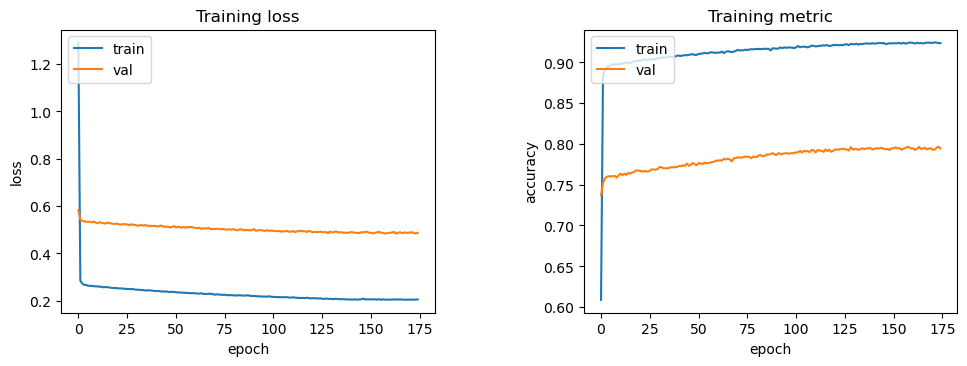

Epoch: 175 - Train Loss: 0.2065 / Validation Loss: 0.4871 / Train acc: 0.9235 / Val acc: 0.7946 / Learning Rate : 0.0000:   0%|          | 175/1000000 [06:01<573:15:55,  2.06s/it]


Starting retraining for model OT fusion - geometric


Epoch: 136 - Train Loss: 0.2135 / Validation Loss: 0.4917 / Train acc: 0.9200 / Val acc: 0.7915 / Learning Rate : 0.0000:   0%|          | 136/1000000 [04:40<571:56:29,  2.06s/it]

Training has converged after 136 epochs (lr < 1e-06)


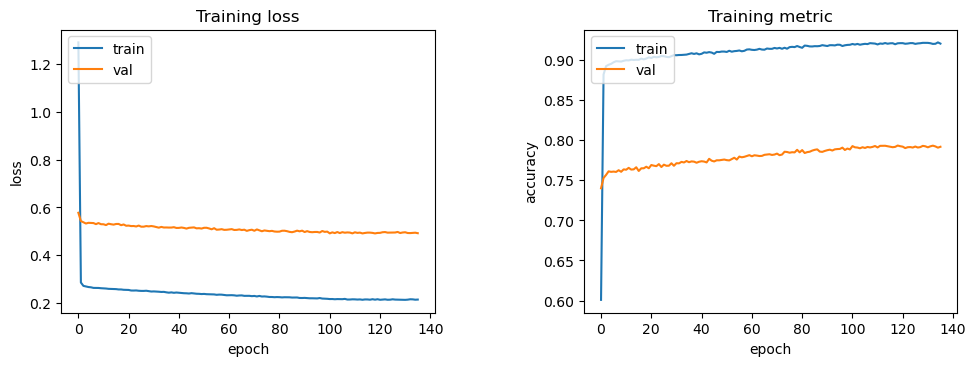

Epoch: 136 - Train Loss: 0.2135 / Validation Loss: 0.4917 / Train acc: 0.9200 / Val acc: 0.7915 / Learning Rate : 0.0000:   0%|          | 136/1000000 [04:40<573:05:26,  2.06s/it]


OT_post_uniform loss: 0.48492252081632614 - accuracy: 0.7993963175015042 - f1: 0.7994584441184998
OT_post_random loss: 0.4923526446024577 - accuracy: 0.7938724522412756 - f1: 0.794719934463501
OT_post_gaussian loss: 0.48564501106739044 - accuracy: 0.7946269084687124 - f1: 0.7942122220993042
OT_post_geometric loss: 0.4972891608874003 - accuracy: 0.7899515126729844 - f1: 0.7915045022964478
vanilla_post loss: 0.47191642969846725 - accuracy: 0.7939265098525873 - f1: 0.7931967973709106
Fold 5/5
Vocabulary Size :  23043


100%|██████████| 5909/5909 [00:00<00:00, 22256.65it/s]


Positive labels ratio (train set): 0.503448275862069
Positive labels ratio (test set): 0.5000846166864106
Dataset initializing done
Starting training for model A


Epoch: 97 - Train Loss: 0.1736 / Validation Loss: 0.4934 / Train acc: 0.9377 / Val acc: 0.8141 / Learning Rate : 0.0000:   0%|          | 97/1000000 [03:29<595:44:46,  2.14s/it]

Training has converged after 97 epochs (lr < 1e-06)


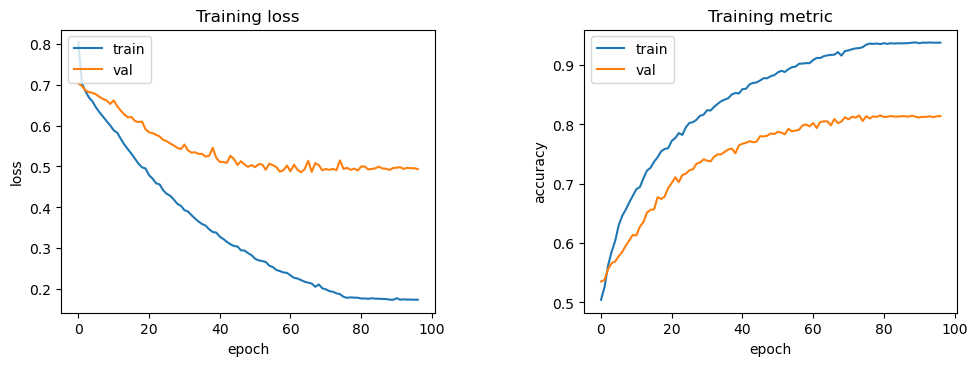

Epoch: 97 - Train Loss: 0.1736 / Validation Loss: 0.4934 / Train acc: 0.9377 / Val acc: 0.8141 / Learning Rate : 0.0000:   0%|          | 97/1000000 [03:29<599:52:50,  2.16s/it]


Starting training for model B


Epoch: 44 - Train Loss: 0.1667 / Validation Loss: 0.3924 / Train acc: 0.9393 / Val acc: 0.8438 / Learning Rate : 0.0000:   0%|          | 44/1000000 [01:35<607:59:36,  2.19s/it]

Training has converged after 44 epochs (lr < 1e-06)


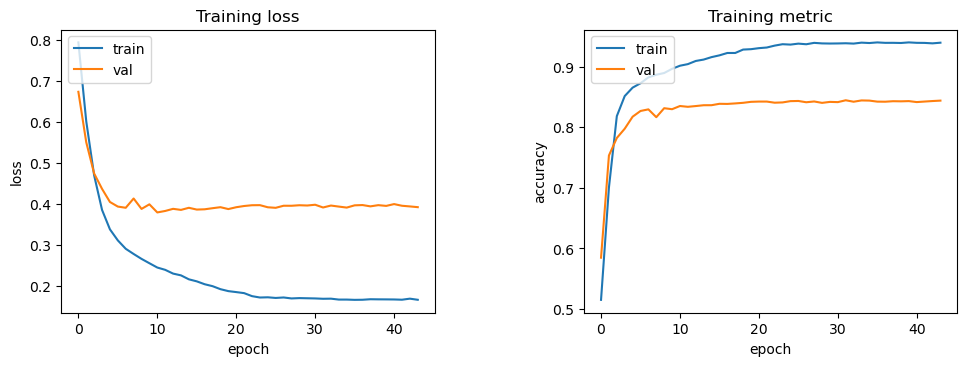

Epoch: 44 - Train Loss: 0.1667 / Validation Loss: 0.3924 / Train acc: 0.9393 / Val acc: 0.8438 / Learning Rate : 0.0000:   0%|          | 44/1000000 [01:35<602:14:51,  2.17s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion suc

Epoch: 64 - Train Loss: 0.1912 / Validation Loss: 0.4402 / Train acc: 0.9359 / Val acc: 0.8148 / Learning Rate : 0.0000:   0%|          | 64/1000000 [02:11<570:26:08,  2.05s/it]

Training has converged after 64 epochs (lr < 1e-06)


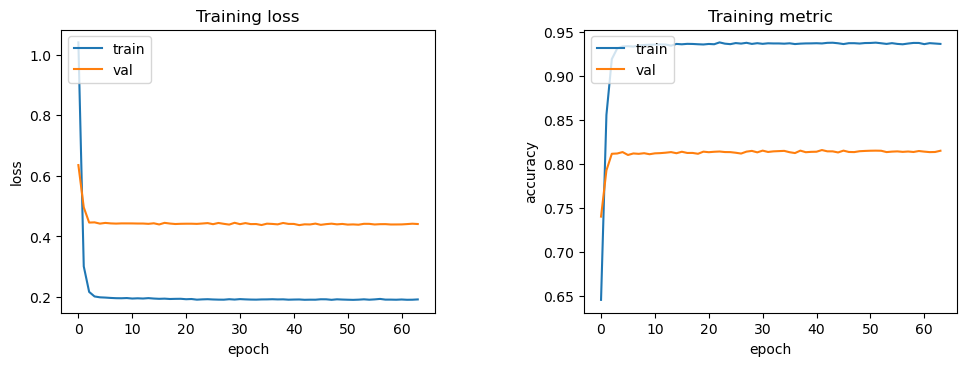

Epoch: 64 - Train Loss: 0.1912 / Validation Loss: 0.4402 / Train acc: 0.9359 / Val acc: 0.8148 / Learning Rate : 0.0000:   0%|          | 64/1000000 [02:12<573:20:01,  2.06s/it]


Starting retraining for model OT fusion - uniform


Epoch: 98 - Train Loss: 0.1895 / Validation Loss: 0.4322 / Train acc: 0.9388 / Val acc: 0.8159 / Learning Rate : 0.0000:   0%|          | 98/1000000 [03:22<570:45:07,  2.05s/it]

Training has converged after 98 epochs (lr < 1e-06)


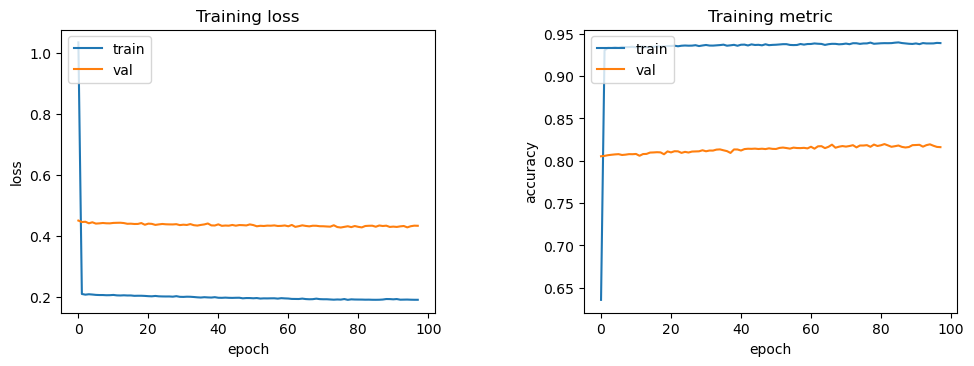

Epoch: 98 - Train Loss: 0.1895 / Validation Loss: 0.4322 / Train acc: 0.9388 / Val acc: 0.8159 / Learning Rate : 0.0000:   0%|          | 98/1000000 [03:22<573:16:09,  2.06s/it]


Starting retraining for model OT fusion - random


Epoch: 100 - Train Loss: 0.1903 / Validation Loss: 0.4326 / Train acc: 0.9385 / Val acc: 0.8168 / Learning Rate : 0.0000:   0%|          | 100/1000000 [03:26<580:59:02,  2.09s/it]

Training has converged after 100 epochs (lr < 1e-06)


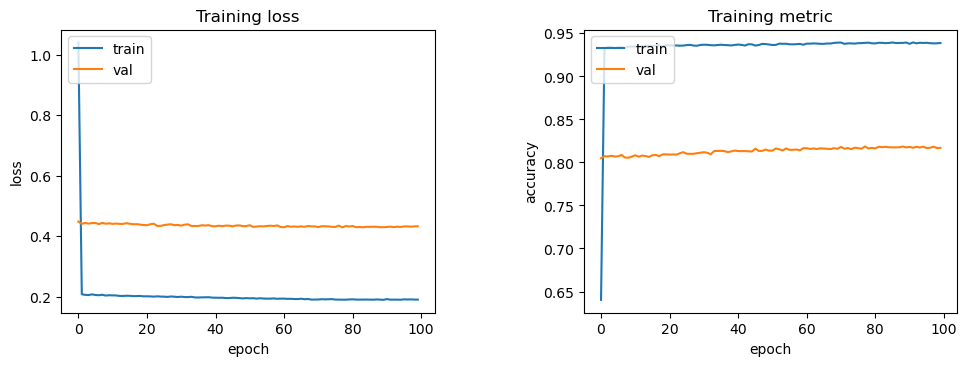

Epoch: 100 - Train Loss: 0.1903 / Validation Loss: 0.4326 / Train acc: 0.9385 / Val acc: 0.8168 / Learning Rate : 0.0000:   0%|          | 100/1000000 [03:26<573:30:50,  2.06s/it]


Starting retraining for model OT fusion - gaussian


Epoch: 87 - Train Loss: 0.1926 / Validation Loss: 0.4334 / Train acc: 0.9379 / Val acc: 0.8147 / Learning Rate : 0.0000:   0%|          | 87/1000000 [02:59<573:09:28,  2.06s/it]

Training has converged after 87 epochs (lr < 1e-06)


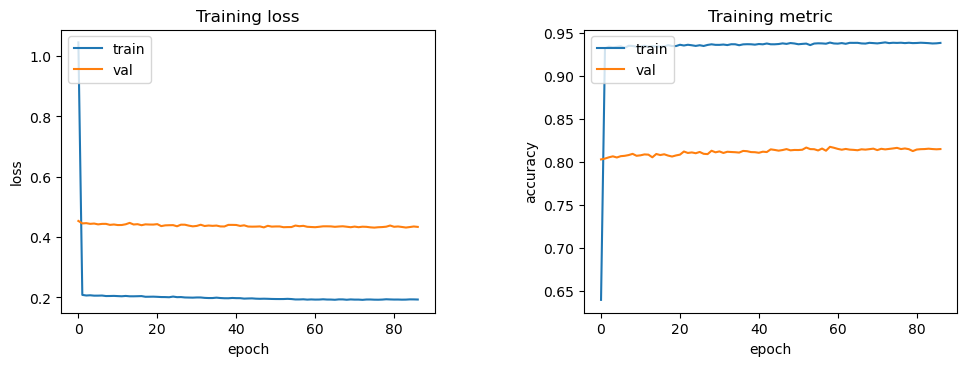

Epoch: 87 - Train Loss: 0.1926 / Validation Loss: 0.4334 / Train acc: 0.9379 / Val acc: 0.8147 / Learning Rate : 0.0000:   0%|          | 87/1000000 [02:59<573:32:16,  2.06s/it]


Starting retraining for model OT fusion - geometric


Epoch: 98 - Train Loss: 0.1951 / Validation Loss: 0.4333 / Train acc: 0.9369 / Val acc: 0.8131 / Learning Rate : 0.0000:   0%|          | 98/1000000 [03:21<571:39:32,  2.06s/it]

Training has converged after 98 epochs (lr < 1e-06)


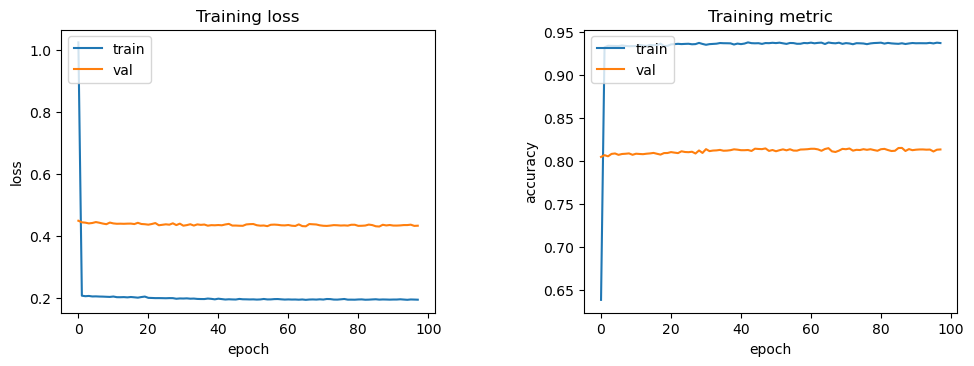

Epoch: 98 - Train Loss: 0.1951 / Validation Loss: 0.4333 / Train acc: 0.9369 / Val acc: 0.8131 / Learning Rate : 0.0000:   0%|          | 98/1000000 [03:22<572:58:54,  2.06s/it]


OT_post_uniform loss: 0.4292568266391754 - accuracy: 0.817738887635379 - f1: 0.8182433843612671
OT_post_random loss: 0.4304913307229678 - accuracy: 0.8192331105219615 - f1: 0.818074107170105
OT_post_gaussian loss: 0.4341362540920575 - accuracy: 0.8143849654031287 - f1: 0.8141817450523376
OT_post_geometric loss: 0.432977336148421 - accuracy: 0.8127820397111913 - f1: 0.8126586675643921
vanilla_post loss: 0.4395066226522128 - accuracy: 0.8137832806859207 - f1: 0.813843309879303
CPU times: total: 3h 9min 14s
Wall time: 2h 34min 29s


In [46]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    for i in range(FOLDS):
        print(f'Fold {i + 1}/{FOLDS}')

        # get training, test set
        train_set, test_set = datasets.pop()

        # build generators
        train_iterator, test_iterator, voc_size, pad_idx, embedding = build_generators(train_set, test_set, device, batch_size=512)

        # train parent models
        train_parent = lambda x: train_early_stopping(model_name=x,
                                                      train_iter=train_iterator,
                                                      valid_iter=test_iterator,
                                                      embedding=embedding,
                                                      pad_idx=pad_idx,
                                                      voc_size=voc_size,
                                                      device=device,
                                                      epochs=EPOCHS,
                                                      lr=LEARNING_RATE,
                                                      save=False)
        print('Starting training for model A')
        modelA = train_parent('A')
        print('Starting training for model B')
        modelB = train_parent('B')

        # model fusion
        # 1) vanilla
        model_fusion_vanilla = vanilla_fusion(modelA=modelA, modelB=modelB, pad_idx=pad_idx, voc_size=voc_size, embedding=embedding, device=device)
        # 2) optimal transport
        # 2.1) uniform
        N_TRIALS = 100
        study = optuna.create_study()
        study.optimize(weighted_fusion(modelA, modelB, train_iterator, test_iterator, embedding, pad_idx, voc_size, device, pmd_name='uniform'), n_trials=N_TRIALS)
        best_weighting_factor = study.best_params['weighting_factor']
        print('Best fusion weight - uniform:', best_weighting_factor)
        model_fusion_uniform = ot_fusion(modelA, modelB, train_iterator, embedding, pad_idx, voc_size,
                                         device, fusion_ratio=best_weighting_factor,
                                         pmd_name='uniform')
        # 2.2) random
        N_TRIALS = 100
        study = optuna.create_study()
        study.optimize(weighted_fusion(modelA, modelB, train_iterator, test_iterator, embedding, pad_idx, voc_size, device, pmd_name='random'), n_trials=N_TRIALS)
        best_weighting_factor = study.best_params['weighting_factor']
        print('Best fusion weight - random:', best_weighting_factor)
        model_fusion_random = ot_fusion(modelA, modelB, train_iterator, embedding, pad_idx, voc_size,
                                         device, fusion_ratio=best_weighting_factor,
                                         pmd_name='random')
        # 2.3) gaussian
        N_TRIALS = 100
        study = optuna.create_study()
        study.optimize(weighted_fusion(modelA, modelB, train_iterator, test_iterator, embedding, pad_idx, voc_size, device, pmd_name='gaussian'), n_trials=N_TRIALS)
        best_weighting_factor = study.best_params['weighting_factor']
        print('Best fusion weight - gaussian:', best_weighting_factor)
        model_fusion_gaussian = ot_fusion(modelA, modelB, train_iterator, embedding, pad_idx, voc_size,
                                         device, fusion_ratio=best_weighting_factor,
                                         pmd_name='gaussian')
        # 2.4) geometric
        N_TRIALS = 100
        study = optuna.create_study()
        study.optimize(weighted_fusion(modelA, modelB, train_iterator, test_iterator, embedding, pad_idx, voc_size, device, pmd_name='geometric'), n_trials=N_TRIALS)
        best_weighting_factor = study.best_params['weighting_factor']
        print('Best fusion weight - geometric:', best_weighting_factor)
        model_fusion_geometric = ot_fusion(modelA, modelB, train_iterator, embedding, pad_idx, voc_size,
                                         device, fusion_ratio=best_weighting_factor,
                                         pmd_name='geometric')

        # evaluate
        # ensure all models on same device
        model_to_cpu = lambda x: x.to(device)
        modelA = model_to_cpu(modelA)
        modelB = model_to_cpu(modelB)
        model_random = new_model(embedding, pad_idx, voc_size, device)
        model_fusion_uniform = model_to_cpu(model_fusion_uniform)
        model_fusion_random = model_to_cpu(model_fusion_random)
        model_fusion_gaussian = model_to_cpu(model_fusion_gaussian)
        model_fusion_geometric = model_to_cpu(model_fusion_geometric)
        model_fusion_vanilla = model_to_cpu(model_fusion_vanilla)

        # test models
        for name, model in zip(('A', 'B', 'random', 'OT_pre_uniform', 'OT_pre_random', 'OT_pre_gaussian', 'OT_pre_geometric', 'vanilla_pre'),
                               (modelA, modelB, model_random, model_fusion_uniform, model_fusion_random, model_fusion_gaussian,
                                model_fusion_geometric, model_fusion_vanilla)):
            loss, acc, f1 = validation(model, test_iterator, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)

            # put into cpu
            to_cpu = lambda x: x.to('cpu') if isinstance(x, torch.Tensor) else x
            loss = to_cpu(loss)
            acc = to_cpu(acc)
            f1 = to_cpu(f1)

            print(name, f'loss: {loss} - accuracy: {acc} - f1: {f1}')
            scores['loss'][name].append(loss), scores['accuracy'][name].append(acc), scores['f1'][name].append(f1)

        # retraining
        retrain = lambda x: train(model=x,
                                  iterator=train_iterator,
                                  valid_iter=test_iterator,
                                  optimizer=torch.optim.SGD(x.parameters(), lr=LEARNING_RATE),
                                  criterion=nn.CrossEntropyLoss(),
                                  epoch=EPOCHS,
                                  clip=1,
                                  device=device)
        # 1) vanilla
        # train with early stopping
        print('Starting retraining for model vanilla fusion')
        retrain(model_fusion_vanilla)

        # 2) optimal transport
        # train with early stopping
        print('Starting retraining for model OT fusion - uniform')
        retrain(model_fusion_uniform)
        print('Starting retraining for model OT fusion - random')
        retrain(model_fusion_random)
        print('Starting retraining for model OT fusion - gaussian')
        retrain(model_fusion_gaussian)
        print('Starting retraining for model OT fusion - geometric')
        retrain(model_fusion_geometric)

        # evaluate
        # ensure all models on same device
        model_fusion_uniform = model_to_cpu(model_fusion_uniform)
        model_fusion_random = model_to_cpu(model_fusion_random)
        model_fusion_gaussian = model_to_cpu(model_fusion_gaussian)
        model_fusion_geometric = model_to_cpu(model_fusion_geometric)
        model_fusion_vanilla = model_to_cpu(model_fusion_vanilla)

        # test models
        for name, model in zip(('OT_post_uniform', 'OT_post_random', 'OT_post_gaussian', 'OT_post_geometric', 'vanilla_post'),
                               (model_fusion_uniform, model_fusion_random, model_fusion_gaussian,
                                model_fusion_geometric, model_fusion_vanilla)):
            loss, acc, f1 = validation(model, test_iterator, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)

            # put into cpu
            to_cpu = lambda x: x.to('cpu') if isinstance(x, torch.Tensor) else x
            loss = to_cpu(loss)
            acc = to_cpu(acc)
            f1 = to_cpu(f1)

            print(name, f'loss: {loss} - accuracy: {acc} - f1: {f1}')
            scores['loss'][name].append(loss), scores['accuracy'][name].append(acc), scores['f1'][name].append(f1)

### Export as LaTeX

In [47]:
model_names_latex = ['Model A', 'Model B', 'Vanilla', 'Vanilla (retraining)', 'Optimal transport (uniform)', 'Optimal transport (uniform - retraining)',
                     'Optimal transport (random)', 'Optimal transport (random - retraining)', 'Optimal transport (gaussian)', 'Optimal transport (gaussian - retraining)', 'Optimal transport (geometric)', 'Optimal transport (geometric - retraining)', 'Untrained model (baseline)']

In [48]:
latex = scores_to_latex(scores, model_names_latex)

                                                  loss  \
A                   [0.471, 0.484, 0.467, 0.46, 0.468]   
B                    [0.41, 0.42, 0.421, 0.444, 0.397]   
vanilla_pre        [1.924, 0.837, 3.169, 0.512, 0.791]   
vanilla_post        [0.478, 0.458, 0.452, 0.472, 0.44]   
OT_pre_uniform     [0.656, 0.477, 0.707, 0.715, 0.449]   
OT_post_uniform     [0.494, 0.428, 0.48, 0.485, 0.429]   
OT_pre_random        [0.65, 0.476, 0.704, 0.72, 0.448]   
OT_post_random      [0.486, 0.427, 0.476, 0.492, 0.43]   
OT_pre_gaussian    [0.653, 0.482, 0.711, 0.715, 0.453]   
OT_post_gaussian   [0.478, 0.434, 0.473, 0.486, 0.434]   
OT_pre_geometric   [0.648, 0.478, 0.706, 0.719, 0.452]   
OT_post_geometric  [0.487, 0.428, 0.473, 0.497, 0.433]   
random             [0.762, 0.907, 0.728, 0.944, 0.726]   

                                              accuracy  \
A                  [0.817, 0.818, 0.826, 0.826, 0.827]   
B                  [0.832, 0.833, 0.832, 0.828, 0.841]   
vanilla_pre  

C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\DL Project\CV\utils.py:1052: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df.to_latex(index=True,


In [49]:
# save as latex (in text format) (optional)
with open('./Output/scores_different_seeds_mass_distributions (weighted fusion).txt','w') as dat:
    dat.write(str(latex))

Notes: weighted fusion collapses to 0, 1 -> use average